__Нейросетевая языковая модель__ 


char-LSTM

Евгений Борисов <esborisov@sevsu.ru>

генерирует следующий символ по предыдущим

In [1]:
import gzip
import re
import numpy as np
from numpy import random as rng
import pandas as pd
from tqdm import tqdm
from os.path import join as pjoin

In [2]:
def ppr(df): return print(len(df))

def replace_patterns(s,pat):
    if len(pat)<1: return s
    return  replace_patterns( re.sub(pat[0][0],pat[0][1],s), pat[1:] )

In [3]:
np.set_printoptions(precision=2) # вывод на печать чисел до 2 знака
pd.options.display.max_colwidth=200 

tqdm.pandas()

In [4]:
FOLDER_RESULT='result'

In [5]:
!mkdir result

mkdir: невозможно создать каталог «result»: Файл существует


## загружаем данные

In [6]:
FILE_DATA = '../data/dostoevsky-besy-p2.txt.gz'
with gzip.open(FILE_DATA,'rt',encoding='utf-8') as f: text = f.read()     
ppr(text)    

465595


In [7]:
print(text[:200]+'...')

БЕСЫ

Федор Михайлович Достоевский





ЧАСТЬ ВТОРАЯ



ГЛАВА ПЕРВАЯ



Ночь



I



Прошло восемь дней. Теперь, когда уже все прошло, и я пишу хронику, мы уже знаем в чем дело; но тогда мы еще ничего...


In [8]:
pat = [
    [r'([\.!\?;]+)',r'\1\n'],
    ['\n+','\n'],
]

data = pd.DataFrame({'line':replace_patterns(text,pat).split('\n')})
data.head(30)

,line
0,БЕСЫ
1,Федор Михайлович Достоевский
2,ЧАСТЬ ВТОРАЯ
3,ГЛАВА ПЕРВАЯ
4,Ночь
5,I
6,Прошло восемь дней.
7,"Теперь, когда уже все прошло, и я пишу хронику, мы уже знаем в чем дело;"
8,"но тогда мы еще ничего не знали, и естественно, что нам представлялись странными разные вещи."
9,По крайней мере мы со Степаном Трофимовичем в первое время заперлись и с испугом наблюдали издали.


In [9]:
data = data.iloc[6:]

In [10]:
data['line'] = data['line'].str.strip()
data['line'].str.len().describe().astype(int)

count    6828
mean       66
std        59
min         0
25%        26
50%        49
75%        89
max       584
Name: line, dtype: int64

In [11]:
ppr(data)
data = data[ data['line'].str.len()>0 ] 
ppr(data)

6828
6827


In [12]:
# data[data['line'].str.len()<1]

## очистка данных

In [13]:
# def tokenize(s): 
#     return [ w.strip() for w in re.split(r'\b| ',s) if w.strip() ]

In [14]:
pat = [
    [r'"|\'',' '],
    [r'\(|\)',','],
    ['\d+','D'],
    ['[a-z•^]+',' '],
    ['\n',' '],
    [',',' , '],
    ['-',' - '],
    [r' +',' ',],
]

data['line'] = data['line']\
    .progress_apply(lambda s: replace_patterns(s.lower(),pat).strip() )
#     .progress_apply(tokenize) 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6827/6827 [00:00<00:00, 54860.85it/s]


In [15]:
%xdel text

In [16]:
ppr(data)
data.sample(4)

6827


,line
6454,"этот пристав - восторженно административная личность , василий иванович флибустьеров , был еще недавним гостем в нашем городе , но уже отличился и прогремел своею непомерною ревностью , своим каки..."
3012,"вся тайна в том , что тут все зависит от взглядов правительства."
141,- проговорил я укоризненно.
670,"вот прочтите это письмо , от гаганова;"


## кодируем текст

In [17]:
# алфавит
abc = set(' '.join( data['line'].values.tolist() ) )
len(abc)

41

In [18]:
abc = { a:i+1 for i,a in enumerate(sorted(abc)) }
zero_symbol = '\t'
abc[zero_symbol] = 0
ppr(abc)
# abc

42


In [19]:
def encode_str(s): 
    return [ abc[c] for c in list(s)]

In [20]:
data['code'] = data['line'].progress_apply(encode_str) 
# lambda s: [ abc[c] for c in list(s)] )

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6827/6827 [00:00<00:00, 73330.07it/s]


## собираем датасет

In [21]:
hist_deep = 15 # глубина истории контекста (символов)

In [22]:
data['code'].str.len().describe([.1,.25,.5,.75,.9,.95,.99]).astype(int)

count    6827
mean       67
std        61
min         0
10%        14
25%        26
50%        49
75%        91
90%       147
95%       188
99%       303
max       595
Name: code, dtype: int64

In [23]:
ppr(data)
data = data[ data['code'].str.len().between(hist_deep+1,data['code'].str.len().quantile(.95)) ] 
ppr(data)

6827
5719


In [24]:
# [ контекст, символ ]
def pack_history(s,hd=hist_deep):
    return [ [ s[i-hd:i], s[i] ] for i in range(hd,len(s)) ] 

In [25]:
d = data['code'].progress_apply(pack_history)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5719/5719 [00:00<00:00, 14622.08it/s]


In [26]:
%%time 

x_context = [] 
x = []
for s in tqdm(d.values.tolist()):
    x_context.append(np.array([ c for c,_ in s ]))
    x.append(np.array([ w for _,w in s ]))
    
x_context = np.vstack(x_context)  # контекст слова
x = np.hstack(x) # номер слова

x_context.shape, x.shape

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5719/5719 [00:00<00:00, 20642.34it/s]

CPU times: user 297 ms, sys: 0 ns, total: 297 ms
Wall time: 295 ms


((285770, 15), (285770,))

In [27]:
%xdel d

## модель

In [28]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import plot_model

In [29]:
x_context.shape

(285770, 15)

In [30]:
abc_len = len(abc) # размер алфавита
hist_deep = x_context.shape[1] # глубина контекста

code_len = 1024 # размер внутреннего представления контекста

hist_deep, abc_len, code_len, 

(15, 42, 1024)

In [31]:
model_name='char-LSTM'

i = Input(shape=(None, abc_len))
o = LSTM(code_len)(i)
o = Dense(abc_len, activation='softmax')(o)
model = Model(i,o)

2022-03-03 11:41:08.188463: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-03 11:41:08.253557: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-03 11:41:08.253732: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-03 11:41:08.254375: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

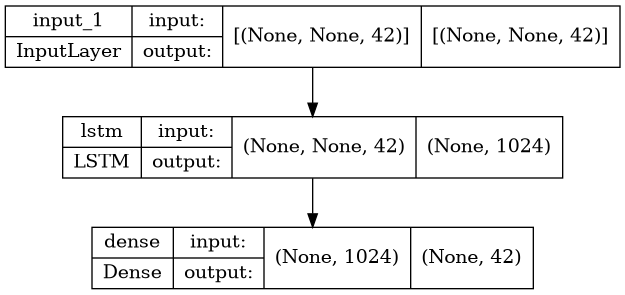

In [32]:
plot_model(model,to_file=pjoin(FOLDER_RESULT,model_name+'.png'), 
                show_layer_names=True, show_shapes=True )

In [33]:
with open( pjoin(FOLDER_RESULT,model_name+'.json'), 'wt') as f: f.write( model.to_json() )

## обучаем модель

In [34]:
learning_rate = 1e-3

optimizer=Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy',metrics=['accuracy'])

In [35]:
# np.eye(abc_len,dtype=int)[x_context[:3]].shape
# np.eye(abc_len,dtype=int)[x[:3]].shape

In [36]:
def encode_bin(seq,al=len(abc)):
    return np.eye(al,dtype=int)[seq]

In [37]:
# преобразовать весь датасет в матрицы OHE займёт очень много памяти
# будем делать это в процессе формирования batch
# построим генератор батчей

# x - номера слов, 
# xc- цепочки номеров слов контекста для x
# batch_size - размер пакета данных
def data_gen(x,xc,batch_size):
    bc = np.ceil(x.shape[0]/batch_size).astype(int) # количество пакетов данных
    while True:
        # перемешиваем номера примеров
        rand_idx = rng.permutation(range(x.shape[0]))
        # делим список индексов на части
        batches_idx = np.array_split(rand_idx,bc)
        # последовательно формируем и выдаём пакеты данных
        for ii in batches_idx:
            yield encode_bin(xc[ii,:]), encode_bin(x[ii]) 

In [38]:
# dg = data_gen(x,x_context,batch_size=8)
# wc,w = next(dg)
# wc.shape,w.shape

In [39]:
%%time 

n_epochs = 64
# batch_size = 6144
batch_size = 2048

hist = model.fit(
    data_gen(x,x_context,batch_size),
    steps_per_epoch = x.shape[0]//batch_size,
    epochs = n_epochs
)

Epoch 1/64


2022-03-03 11:41:12.115857: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8300


139/139 [==============================] - 40s 279ms/step - loss: 2.9585 - accuracy: 0.1967
Epoch 2/64
139/139 [==============================] - 39s 279ms/step - loss: 2.4314 - accuracy: 0.2987
Epoch 3/64
139/139 [==============================] - 39s 281ms/step - loss: 2.2646 - accuracy: 0.3368
Epoch 4/64
139/139 [==============================] - 39s 280ms/step - loss: 2.1130 - accuracy: 0.3810
Epoch 5/64
139/139 [==============================] - 39s 278ms/step - loss: 1.9714 - accuracy: 0.4213
Epoch 6/64
139/139 [==============================] - 39s 281ms/step - loss: 1.8493 - accuracy: 0.4566
Epoch 7/64
139/139 [==============================] - 39s 278ms/step - loss: 1.7417 - accuracy: 0.4862
Epoch 8/64
139/139 [==============================] - 38s 276ms/step - loss: 1.6462 - accuracy: 0.5124
Epoch 9/64
139/139 [==============================] - 38s 276ms/step - loss: 1.5538 - accuracy: 0.5379
Epoch 10/64
139/139 [==============================] - 39s 279ms/step - loss: 1.4623

In [ ]:
# model.save_weights( pjoin(FOLDER_RESULT,model_name+'-%02d.tf'%(n_epochs) ), save_format='tf') 

---

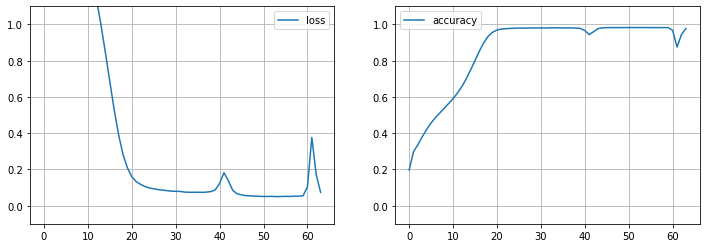

In [40]:
from matplotlib import pyplot as plt

k = hist.history.keys()

w,h = 6,4

fig,ax = plt.subplots(1,len(k),figsize=(w*len(k),h))
for i,n in enumerate(k):
    ax[i].plot(hist.history[n],label=n)
    ax[i].grid(True)
    ax[i].legend()
    ax[i].set_ylim([-.1,1.1])

## тестируем

In [41]:
# !ls result

In [42]:
# from tensorflow.keras.models import model_from_json
# # from tensorflow.keras.models import load_model

# fname='result/charCNN-BiLSTM.json'
# with open( fname, 'rt') as f: model = model_from_json(f.read())
# #model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=['accuracy'])

# fname = 'result/charCNN-BiLSTM-64.tf'
# model.load_weights( fname )     

In [43]:
abc_inv = { abc[k]:k for k in abc } # декодер символов

In [44]:
# начальный контекст
s = data['line'].sample().values[0][:hist_deep]
s

'- вдруг вскинул'

In [45]:
o = s + ' | ' # результат

for i in range(400):
    t = encode_bin(encode_str(s))[np.newaxis,:]
    p = model.predict(t)
    r = np.argmax(p)
    c = abc_inv[r]
    s = s[1:] + c
    o += c
    if c == '.': break

o

'- вдруг вскинул | ся николай всеволодович , - вы , стало быть , вы брали деньги.'

In [46]:
s

'ы брали деньги.'